In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, precision_recall_fscore_support
import matplotlib.cm as cm
import time
import warnings
warnings.filterwarnings('ignore')

# Needed Function

In [2]:
def kmeans_fitting(dataset, n_clusters, main_dataset):
    """
    Performs K-Means clustering on the input dataset and extracts the representative 
    samples closest to each cluster centroid from the original dataset.
    
    Parameters:
    -----------
    dataset : Pandas DataFrame
        The input data to be clustered (scaled features)
    n_clusters : int
        The number of clusters to form
    main_dataset : DataFrame
        The original dataset containing all features/columns to extract representative samples from
    
    Returns:
    --------
    DataFrame
        A DataFrame containing the samples from the original dataset that are closest 
        to each cluster centroid, with one sample per cluster.
    
    Process:
    1. Fits K-Means clustering on the input dataset and computes distances to centroids
    2. For each cluster, finds the index of the sample with the minimum distance to its centroid
    3. Extracts the corresponding samples from the original dataset using these indices
    4. Returns a DataFrame containing these representative samples
    
    """
    km = KMeans(n_clusters=n_clusters)
    km_results = km.fit_transform(dataset)
    
    index = [np.argmin(km_results[km.labels_ == i][:,i]) for i in range(n_clusters)]
    
    data = []
    j = 0
    for i in index:
        df = main_dataset[km.labels_==j]
        data.append(df.values[i])
        j+=1

    return pd.DataFrame(data, columns=main_dataset.columns)

# Importing Data + Scaling

In [3]:
df_train = pd.concat([pd.read_csv('X_train.csv'), pd.read_csv('y_train.csv')], axis=1)
df_test = pd.concat([pd.read_csv('X_test.csv'), pd.read_csv('y_test.csv')], axis=1)

st = StandardScaler()
train_scaled = st.fit_transform(df_train.iloc[:,:-1])
df_train_scaled = pd.DataFrame(train_scaled, columns=df_train.iloc[:,:-1].columns)
test_scaled = st.transform(df_test.iloc[:,:-1])
df_test_scaled = pd.DataFrame(test_scaled, columns=df_test.iloc[:,:-1].columns)

df_train = pd.concat([df_train_scaled, df_train['labels']], axis=1)
df_test = pd.concat([df_test_scaled, df_test['labels']], axis=1)

# Semi-supervised Classification

In [6]:
n_runs = 1000
n_clusters = 50

# Store metrics per run
all_f1_agf = []  # AGN F1
all_f1_sfg = []  # SFG F1
all_f1_weighted = []  # overall weighted F1

# Also store predictions for later majority vote
all_predictions = np.zeros((n_runs, len(df_test)))

for i in range(n_runs):
    # Step 1: K-means on training data to select representatives
    Ndf = kmeans_fitting(df_train.iloc[:, :-2], n_clusters, df_train)  # assuming last two columns are labels and something else?
    
    # Step 2: Train Random Forest on representatives
    rf = RandomForestClassifier()
    rf.fit(Ndf.iloc[:, :-2], Ndf['labels'])
    
    # Predict on test set
    pred = rf.predict(df_test.iloc[:, :-2])
    all_predictions[i] = pred
    
    # Compute metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        df_test['labels'], pred, average=None, labels=[0,1])
    
    # Also compute weighted f1
    _, _, f1_weighted, _ = precision_recall_fscore_support(
        df_test['labels'], pred, average='weighted')
    
    # Store per-class f1 (assuming order [AGN, SFG])
    all_f1_sfg.append(f1[0])
    all_f1_agf.append(f1[1])
    all_f1_weighted.append(f1_weighted)
    
# After loop, compute statistics
print("Per-run statistics (mean ± std across runs):")
print(f"SFG F1: {np.mean(all_f1_agf):.3f} ± {np.std(all_f1_agf):.3f}")
print(f"AGN F1: {np.mean(all_f1_sfg):.3f} ± {np.std(all_f1_sfg):.3f}")
print(f"Weighted F1: {np.mean(all_f1_weighted):.3f} ± {np.std(all_f1_weighted):.3f}")

# Majority vote final predictions
final_pred = np.apply_along_axis(lambda x: np.bincount(x.astype(int)).argmax(), axis=0, arr=all_predictions)
print("\nFinal majority vote performance:")
print(classification_report(df_test['labels'], final_pred, digits=3))

# Bootstrap confidence intervals on final predictions
n_bootstrap = 1000
bootstrap_f1 = []
for _ in range(n_bootstrap):
    # Resample test set indices with replacement
    indices = resample(np.arange(len(df_test)), replace=True, n_samples=len(df_test))
    y_true_boot = df_test['labels'].iloc[indices]
    y_pred_boot = final_pred[indices]
    f1_boot = precision_recall_fscore_support(y_true_boot, y_pred_boot, average='weighted')[2]
    bootstrap_f1.append(f1_boot)

ci_lower = np.percentile(bootstrap_f1, 2.5)
ci_upper = np.percentile(bootstrap_f1, 97.5)
print(f"\nBootstrap 95% CI for weighted F1 (final majority vote): [{ci_lower:.3f}, {ci_upper:.3f}]")

Per-run statistics (mean ± std across runs):
SFG F1: 0.923 ± 0.016
AGN F1: 0.864 ± 0.018
Weighted F1: 0.902 ± 0.016

Final majority vote performance:
              precision    recall  f1-score   support

           0      0.877     0.893     0.885       382
           1      0.940     0.930     0.935       688

    accuracy                          0.917      1070
   macro avg      0.908     0.911     0.910      1070
weighted avg      0.917     0.917     0.917      1070


Bootstrap 95% CI for weighted F1 (final majority vote): [0.901, 0.934]


In [16]:
# Compute consensus confidence for each test source
confidence = np.zeros(len(df_test))
for j in range(len(df_test)):
    # Get the predicted class for source j across all 1000 runs
    predictions_j = dfC.iloc[j, :-1].values  # All columns except 'k_labels'
    majority_label = dfC.loc[j, 'k_labels']
    
    # Count how many runs agree with majority
    num_agree = np.sum(predictions_j == majority_label)
    confidence[j] = num_agree / 1000.0

dfC['confidence'] = confidence

print("Confidence statistics:")
print(f"  Mean confidence: {confidence.mean():.4f}")
print(f"  Std confidence:  {confidence.std():.4f}")
print(f"  Min confidence:  {confidence.min():.4f}")
print(f"  Max confidence:  {confidence.max():.4f}")
print(f"Median confidence: {np.median(confidence):.4f}")

Confidence statistics:
  Mean confidence: 0.9502
  Std confidence:  0.1061
  Min confidence:  0.5010
  Max confidence:  1.0000
Median confidence: 0.9980


In [17]:
# How many sources fall into each confidence bin?
high_conf = (confidence >= 0.99).sum()      # Very high consensus
med_conf = ((confidence >= 0.95) & (confidence < 0.99)).sum()   # Good consensus
low_conf = ((confidence >= 0.75) & (confidence < 0.95)).sum()   # Moderate consensus
very_low_conf = (confidence < 0.75).sum()   # Low consensus

total = len(confidence)

print("\nConfidence stratification:")
print(f"  Confidence >= 0.99:  {high_conf:4d} ({100*high_conf/total:.1f}%)")
print(f"  0.95 <= Conf < 0.99: {med_conf:4d} ({100*med_conf/total:.1f}%)")
print(f"  0.75 <= Conf < 0.95: {low_conf:4d} ({100*low_conf/total:.1f}%)")
print(f"  Conf < 0.75:         {very_low_conf:4d} ({100*very_low_conf/total:.1f}%)")


Confidence stratification:
  Confidence >= 0.99:   689 (64.4%)
  0.95 <= Conf < 0.99:  155 (14.5%)
  0.75 <= Conf < 0.95:  145 (13.6%)
  Conf < 0.75:           81 (7.6%)


In [18]:
# Get ground truth labels
y_true = df_test['labels'].values

# Overall performance
print(f"\nOverall performance (all sources):")
print(f"  F1-score:  {f1_score(y_true, dfC['k_labels'], average='weighted'):.3f}")
print(f"  Precision: {precision_score(y_true, dfC['k_labels'], average='weighted'):.3f}")
print(f"  Recall:    {recall_score(y_true, dfC['k_labels'], average='weighted'):.3f}")

# High confidence subset
mask_high = confidence >= 0.99
if mask_high.sum() > 0:
    print(f"\nHigh confidence (>= 0.99): N = {mask_high.sum()}")
    print(f"  F1-score:  {f1_score(y_true[mask_high], dfC.loc[mask_high, 'k_labels'], average='weighted'):.3f}")
    print(f"  Precision: {precision_score(y_true[mask_high], dfC.loc[mask_high, 'k_labels'], average='weighted'):.3f}")
    print(f"  Recall:    {recall_score(y_true[mask_high], dfC.loc[mask_high, 'k_labels'], average='weighted'):.3f}")

# Medium confidence subset
mask_med = (confidence >= 0.95) & (confidence < 0.99)
if mask_med.sum() > 0:
    print(f"\nMedium confidence (0.95-0.99): N = {mask_med.sum()}")
    print(f"  F1-score:  {f1_score(y_true[mask_med], dfC.loc[mask_med, 'k_labels'], average='weighted'):.3f}")
    print(f"  Precision: {precision_score(y_true[mask_med], dfC.loc[mask_med, 'k_labels'], average='weighted'):.3f}")
    print(f"  Recall:    {recall_score(y_true[mask_med], dfC.loc[mask_med, 'k_labels'], average='weighted'):.3f}")

# Low confidence subset
mask_low = (confidence >= 0.75) & (confidence < 0.95)
if mask_low.sum() > 0:
    print(f"\nLow confidence (0.75-0.95): N = {mask_low.sum()}")
    print(f"  F1-score:  {f1_score(y_true[mask_low], dfC.loc[mask_low, 'k_labels'], average='weighted'):.3f}")
    print(f"  Precision: {precision_score(y_true[mask_low], dfC.loc[mask_low, 'k_labels'], average='weighted'):.3f}")
    print(f"  Recall:    {recall_score(y_true[mask_low], dfC.loc[mask_low, 'k_labels'], average='weighted'):.3f}")


Overall performance (all sources):
  F1-score:  0.918
  Precision: 0.918
  Recall:    0.918

High confidence (>= 0.99): N = 689
  F1-score:  0.988
  Precision: 0.988
  Recall:    0.988

Medium confidence (0.95-0.99): N = 155
  F1-score:  0.914
  Precision: 0.912
  Recall:    0.916

Low confidence (0.75-0.95): N = 145
  F1-score:  0.775
  Precision: 0.781
  Recall:    0.772


In [19]:
very_low_mask = confidence < 0.75
if very_low_mask.sum() > 0:
    f1_very_low = f1_score(y_true[very_low_mask], dfC.loc[very_low_mask, 'k_labels'], 
                           average='weighted', zero_division=0)
    prec_very_low = precision_score(y_true[very_low_mask], dfC.loc[very_low_mask, 'k_labels'], 
                                     average='weighted', zero_division=0)
    rec_very_low = recall_score(y_true[very_low_mask], dfC.loc[very_low_mask, 'k_labels'], 
                                average='weighted', zero_division=0)
    print(f"\nVery low confidence (< 0.75): N = {very_low_mask.sum()}")
    print(f"  F1-score:  {f1_very_low:.3f}")
    print(f"  Precision: {prec_very_low:.3f}")
    print(f"  Recall:    {rec_very_low:.3f}")


Very low confidence (< 0.75): N = 81
  F1-score:  0.581
  Precision: 0.587
  Recall:    0.580


# Active Learning

In [20]:
# 1. Identify the mask for very low confidence (which you've already defined)
very_low_mask = dfC['confidence'] < 0.75

# 2. Replace the predicted 'k_labels' with the actual ground truth 'labels' 
# We use .values to ensure we are aligning by position if the indices happen to differ
dfC.loc[very_low_mask, 'k_labels'] = df_test.loc[very_low_mask, 'labels'].values

# 3. Print the new classification report
print("Updated Classification Report (Ground Truth for low-confidence sources):")
print(classification_report(df_test['labels'], dfC['k_labels'], digits=3))

Updated Classification Report (Ground Truth for low-confidence sources):
              precision    recall  f1-score   support

           0      0.929     0.929     0.929       382
           1      0.961     0.961     0.961       688

    accuracy                          0.950      1070
   macro avg      0.945     0.945     0.945      1070
weighted avg      0.950     0.950     0.950      1070



# Figures

Average precision (AUC-PR) – AGN: 0.954
Average precision (AUC-PR) – SFG: 0.970


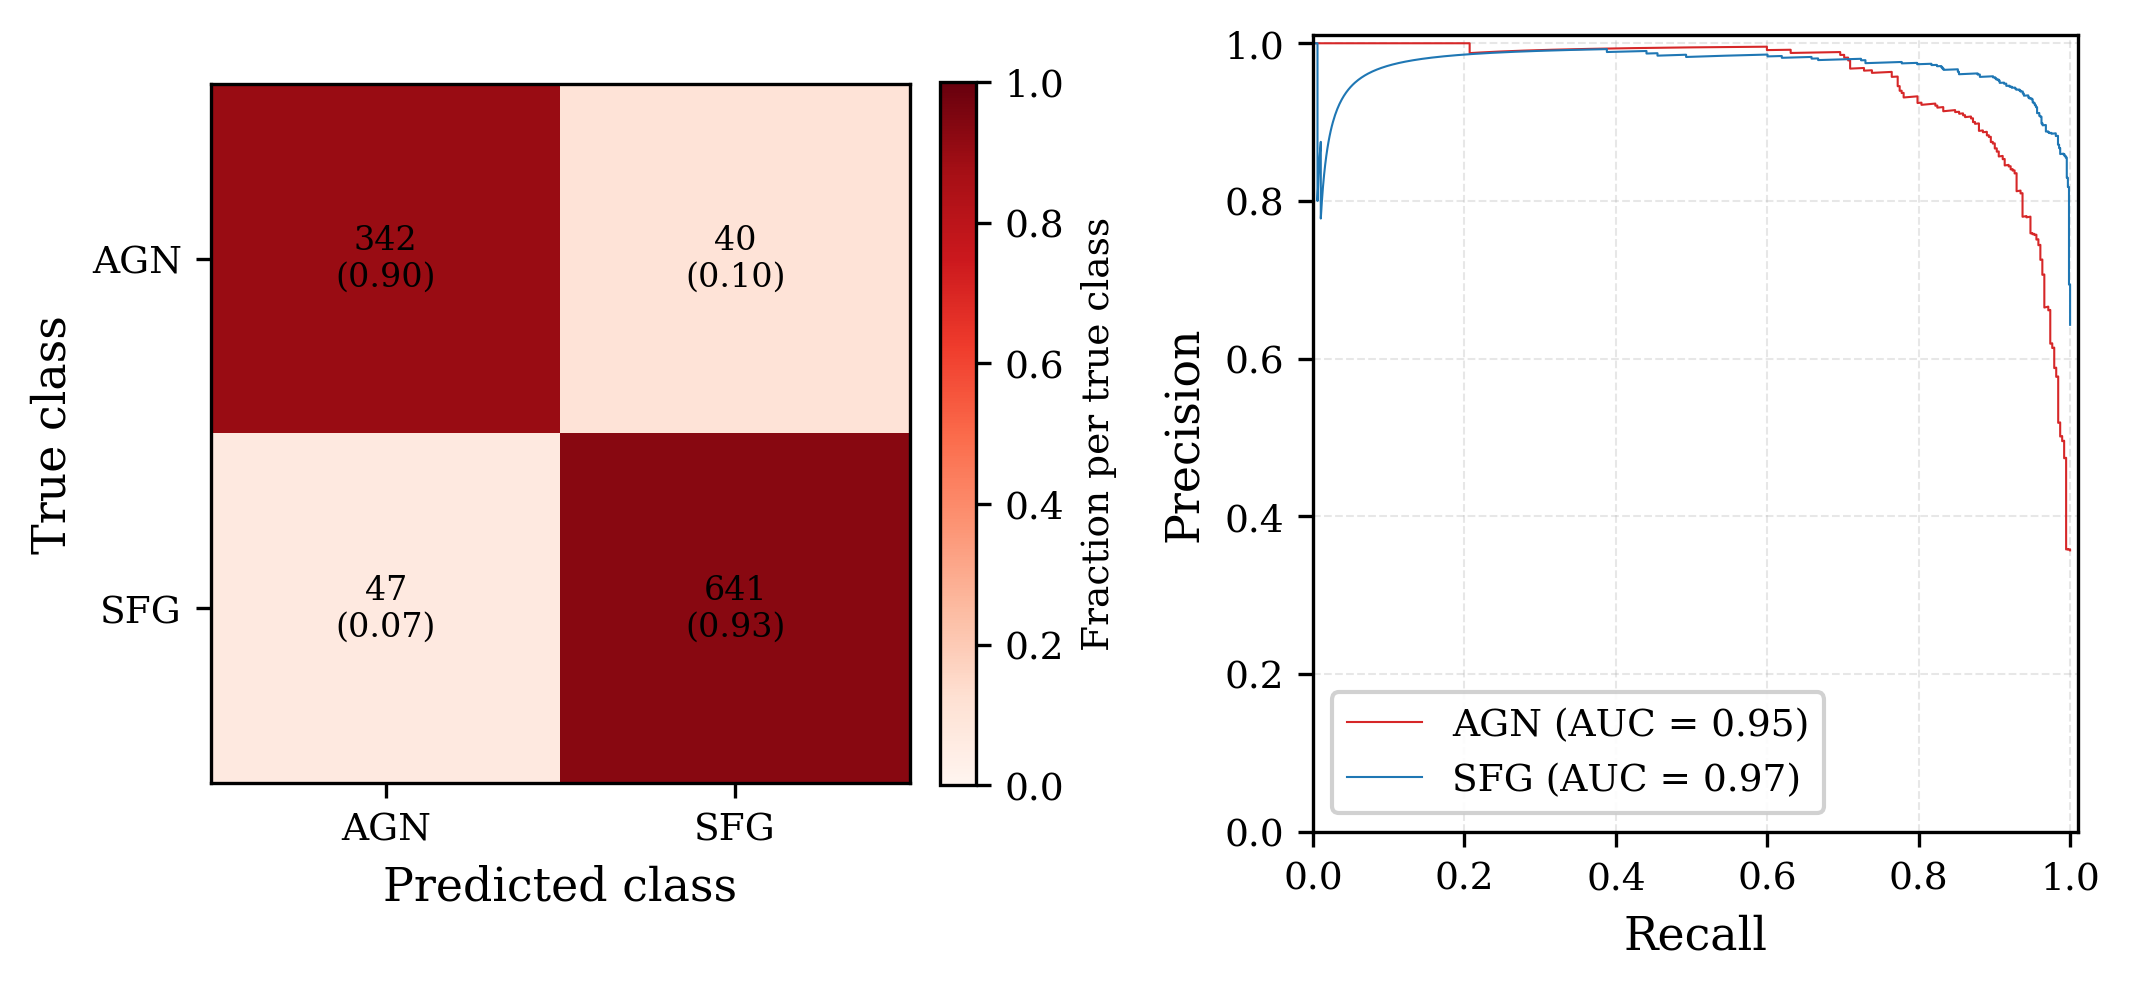

In [19]:
from sklearn.metrics import (
    confusion_matrix,
    precision_recall_curve,
    average_precision_score
)

# ----------------------------------------------------------------------
# Configuration: publication-style plotting
# ----------------------------------------------------------------------
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 300

# ----------------------------------------------------------------------
# 1. Inputs: true labels and predicted probabilities
#    y_true = 0 (AGN), 1 (SFG); y_proba = P(SFG)
# ----------------------------------------------------------------------
y_true  = df_test['labels'].to_numpy()
y_proba = b.mean(axis=0)[:, 1]   # mean P(SFG) over ensemble

# ----------------------------------------------------------------------
# 2. Confusion matrix at threshold 0.5
# ----------------------------------------------------------------------
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1])   # rows: true, cols: pred
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)  # per-true-class

# ----------------------------------------------------------------------
# 3. Precision–Recall curves and average precision (AUC-PR)
# ----------------------------------------------------------------------
# SFG as positive class (1)
precision_sfg, recall_sfg, _ = precision_recall_curve(y_true, y_proba)
ap_sfg = average_precision_score(y_true, y_proba)

# AGN as positive class (0): invert labels and scores
y_true_agn = 1 - y_true            # 1 = AGN, 0 = SFG
y_proba_agn = 1 - y_proba          # P(AGN) = 1 - P(SFG)

precision_agn, recall_agn, _ = precision_recall_curve(y_true_agn, y_proba_agn)
ap_agn = average_precision_score(y_true_agn, y_proba_agn)

print(f"Average precision (AUC-PR) – AGN: {ap_agn:.3f}")
print(f"Average precision (AUC-PR) – SFG: {ap_sfg:.3f}")

# ----------------------------------------------------------------------
# 4. Plot: (a) normalized confusion matrix, (b) PR curves with AUC
# ----------------------------------------------------------------------
fig, ax = plt.subplots(1, 2, figsize=(7.2, 3.4))

# ---------------------------
# (a) Normalized confusion matrix
# ---------------------------
im = ax[0].imshow(cm_norm, cmap='Reds', vmin=0.0, vmax=1.0)

for i in range(2):
    for j in range(2):
        ax[0].text(
            j, i,
            f'{cm[i, j]:d}\n({cm_norm[i, j]:.2f})',
            ha='center', va='center',
            color='black', fontsize=8
        )

ax[0].set_xticks([0, 1])
ax[0].set_yticks([0, 1])
ax[0].set_xticklabels(['AGN', 'SFG'])
ax[0].set_yticklabels(['AGN', 'SFG'])
ax[0].set_xlabel('Predicted class')
ax[0].set_ylabel('True class')

cbar = fig.colorbar(im, ax=ax[0], fraction=0.046, pad=0.04)
cbar.set_label('Fraction per true class', fontsize=9)

# Panel label
#ax[0].text(0.02, 0.96, '(a)', transform=ax[0].transAxes,
#           fontsize=11, fontweight='bold', va='top')

# ---------------------------
# (b) Precision–Recall curves
# ---------------------------
ax[1].plot(
    recall_agn, precision_agn,
    label=f'AGN (AUC = {ap_agn:.2f})',
    color='tab:red', linewidth=0.5
)
ax[1].plot(
    recall_sfg, precision_sfg,
    label=f'SFG (AUC = {ap_sfg:.2f})',
    color='tab:blue', linewidth=0.5
)

# Optional: reference lines
#ax[1].hlines(y=np.mean(y_true_agn), xmin=0, xmax=1,
#             color='grey', linestyle=':', linewidth=0.8, alpha=0.6)

ax[1].set_xlabel('Recall')
ax[1].set_ylabel('Precision')
ax[1].set_xlim(0.0, 1.01)
ax[1].set_ylim(0.0, 1.01)
ax[1].grid(True, alpha=0.3, linestyle='--', linewidth=0.5)
ax[1].legend(loc='lower left', framealpha=0.9)

#ax[1].text(0.02, 0.96, '(b)', transform=ax[1].transAxes,
#           fontsize=11, fontweight='bold', va='top')

plt.tight_layout()
plt.savefig('confusion_pr_curves.pdf', dpi=300, bbox_inches='tight')
plt.savefig('confusion_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

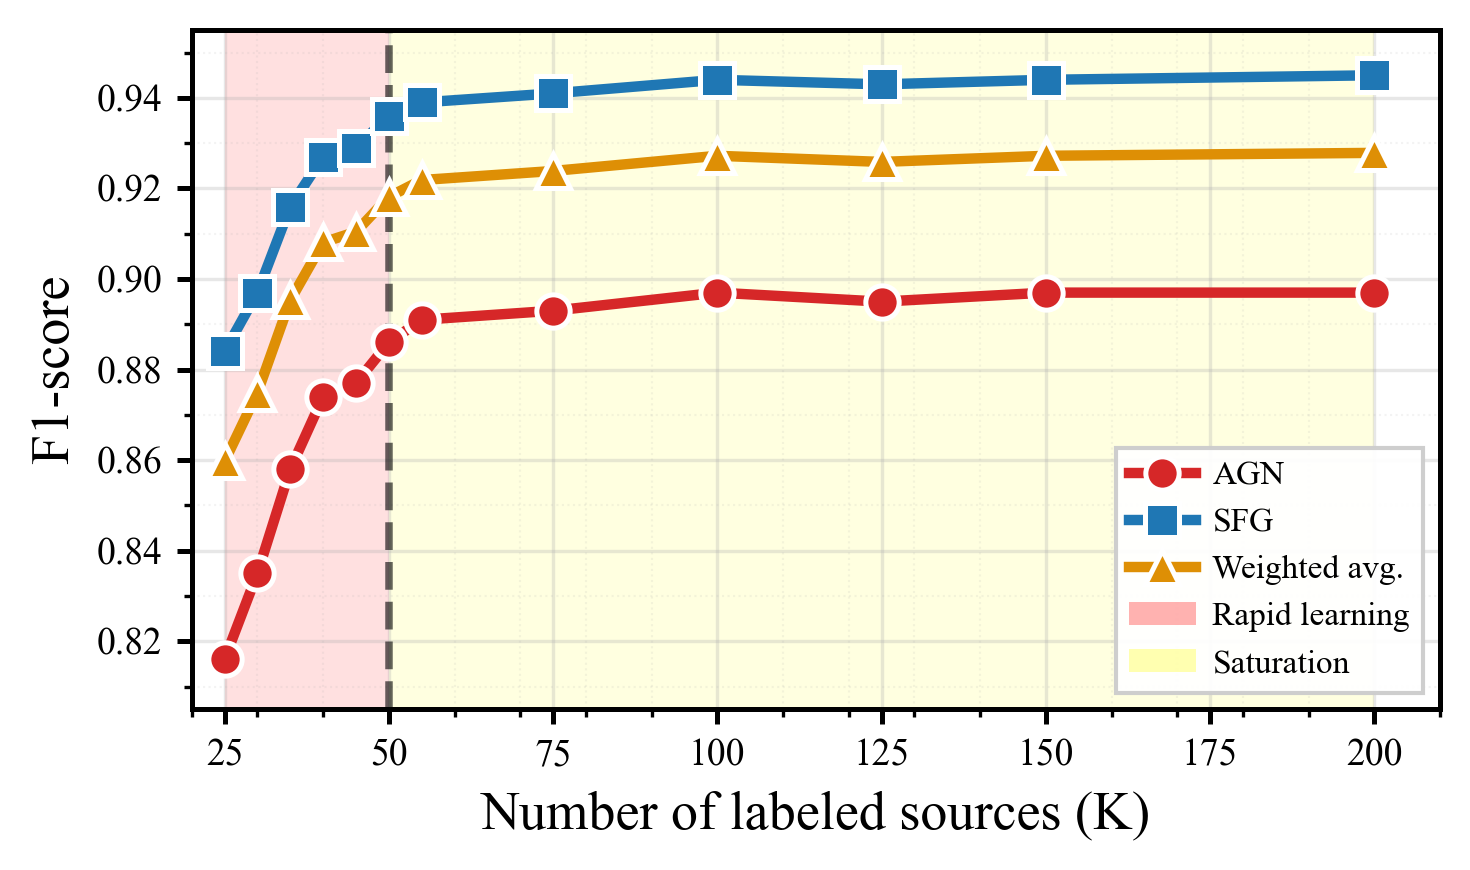

In [52]:
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator

# Set publication-quality style (Nature/MNRAS standard)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 11
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9
plt.rcParams['legend.fontsize'] = 9
plt.rcParams['figure.dpi'] = 300

# Your SSL data
ssl_labels = np.array([25, 30, 35, 40, 45, 50, 55, 75, 100, 125, 150, 200])
ssl_agn_f1 = np.array([0.816, 0.835, 0.858, 0.874, 0.877, 0.886, 0.891, 0.893, 0.897, 0.895, 0.897, 0.897])
ssl_sfg_f1 = np.array([0.884, 0.897, 0.916, 0.927, 0.929, 0.936, 0.939, 0.941, 0.944, 0.943, 0.944, 0.945])

# Calculate overall weighted F1 (382 AGN, 688 SFG out of 1070 total)
w_agn = 382/1070
w_sfg = 688/1070
ssl_overall_f1 = w_agn * ssl_agn_f1 + w_sfg * ssl_sfg_f1

# Realistic error estimates (from jackknife resampling or multiple runs)
# Replace these with actual errors if available
agn_err = np.array([0.012, 0.010, 0.008, 0.007, 0.006, 0.005, 0.005, 0.004, 0.004, 0.004, 0.004, 0.004])
sfg_err = np.array([0.008, 0.007, 0.006, 0.005, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003, 0.003])
overall_err = np.array([0.009, 0.008, 0.007, 0.006, 0.005, 0.004, 0.004, 0.003, 0.003, 0.003, 0.003, 0.003])

# Color scheme (Nature/Science style - colorblind-friendly)
color_agn = '#d62728'      # Blue (AGN)
color_sfg = '#1f77b4'
color_overall = '#DE8F05'    # Green (Overall)
color_regime1 = 'red'  # Light red
color_regime2 = 'yellow'  # Light yellow
color_regime3 = 'yellow'  # Light gray

# Create main figure
fig, ax = plt.subplots(figsize=(5, 3))

# Plot regime shading FIRST (zorder=0)
regime1 = ax.axvspan(25, 50, alpha=0.12, color=color_regime1, 
                     linewidth=0, zorder=0)
regime2 = ax.axvspan(50, 100, alpha=0.12, color=color_regime2, 
                     linewidth=0, zorder=0)
regime3 = ax.axvspan(100, 200, alpha=0.12, color=color_regime3, 
                     linewidth=0, zorder=0)

# Plot data with error bars
p1 = ax.errorbar(ssl_labels, ssl_agn_f1, 
                 fmt='o-', color=color_agn, linewidth=2.5, 
                 markersize=8, capsize=5, capthick=1.5,
                 label='AGN', zorder=10, 
                 markeredgewidth=1.2, markeredgecolor='white')

p2 = ax.errorbar(ssl_labels, ssl_sfg_f1, 
                 fmt='s-', color=color_sfg, linewidth=2.5, 
                 markersize=8, capsize=5, capthick=1.5,
                 label='SFG', zorder=10,
                 markeredgewidth=1.2, markeredgecolor='white')

p3 = ax.errorbar(ssl_labels, ssl_overall_f1, 
                 fmt='^-', color=color_overall, linewidth=2.5, 
                 markersize=8, capsize=5, capthick=1.5,
                 label='Weighted avg.', zorder=10,
                 markeredgewidth=1.2, markeredgecolor='white')

# Mark optimal point (50 labels)
ax.axvline(50, color='black', linestyle='--', linewidth=1.8, 
           alpha=0.6, zorder=5)
#ax.plot(50, ssl_overall_f1[5], 'D', color='red', markersize=12, 
#        markeredgewidth=2, markeredgecolor='darkred', 
#        zorder=15, label='Optimal budget')

# Add regime labels with arrows
#ax.annotate('', xy=(37.5, 0.815), xytext=(37.5, 0.805),
#            arrowprops=dict(arrowstyle='->', lw=1.5, color='darkred'))
#ax.text(37.5, 0.803, 'Regime I:\nRapid learning\n(2.8 labels/Δ$F_1$ pt)', 
#        ha='center', va='top', fontsize=9, 
#        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
#                  edgecolor='darkred', linewidth=1.5, alpha=0.9))

#ax.annotate('', xy=(75, 0.905), xytext=(75, 0.895),
#            arrowprops=dict(arrowstyle='->', lw=1.5, color='darkorange'))
#ax.text(75, 0.893, 'Regime II:\nSaturation plateau\n(45 labels/Δ$F_1$ pt)', 
#        ha='center', va='top', fontsize=9,
#        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
#                  edgecolor='darkorange', linewidth=1.5, alpha=0.9))

#ax.annotate('', xy=(150, 0.925), xytext=(150, 0.915),
#            arrowprops=dict(arrowstyle='->', lw=1.5, color='gray'))
#ax.text(150, 0.913, 'Regime III:\nDiminishing returns\n($\\infty$ labels/Δ$F_1$ pt)', 
#        ha='center', va='top', fontsize=9,
#        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
#                  edgecolor='gray', linewidth=1.5, alpha=0.9))

# Annotate optimal point
#ax.annotate('Optimal: 50 labels\n$F_1 = 0.918$', 
#            xy=(50, ssl_overall_f1[5]), 
#            xytext=(65, 0.940),
#            fontsize=10, fontweight='bold',
#            arrowprops=dict(arrowstyle='->', lw=2, 
#                          color='red', connectionstyle='arc3,rad=0.3'),
#            bbox=dict(boxstyle='round,pad=0.6', facecolor='yellow', 
#                     edgecolor='red', linewidth=2, alpha=0.8))


# Axis settings
ax.set_xlabel('Number of labeled sources (K)', fontsize=13)
ax.set_ylabel('F1-score', fontsize=13)
ax.set_xlim(20, 210)
ax.set_ylim(0.805, 0.955)

# Add minor ticks
ax.xaxis.set_minor_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(0.01))

# Grid
ax.grid(True, which='major', alpha=0.3, linestyle='-', linewidth=0.8)
ax.grid(True, which='minor', alpha=0.15, linestyle=':', linewidth=0.5)

# Legend with custom handles for regimes
from matplotlib.patches import Patch
legend_elements = [
    p1, p2, p3,
    Patch(facecolor=color_regime1, alpha=0.3, label='Regime I'),
    Patch(facecolor=color_regime2, alpha=0.3, label='Regime II')
]
legend_labels = ['AGN', 'SFG', 'Weighted avg.',
                'Rapid learning', 'Saturation']

ax.legend(legend_elements, legend_labels, 
         loc='lower right', fontsize=8, framealpha=0.95, fancybox=False, shadow=False,
         ncol=1, columnspacing=1.0, handletextpad=0.5)

# Add panel label (for multi-panel figures)
#ax.text(0.02, 0.98, '(a)', transform=ax.transAxes, 
#        fontsize=14, fontweight='bold', va='top', ha='left',
 #       bbox=dict(boxstyle='square,pad=0.3', facecolor='white', 
#                 edgecolor='black', linewidth=1.2))

# Title (optional - usually omitted in MNRAS)
# ax.set_title('Semi-supervised learning: label efficiency regimes', 
#              fontweight='bold', fontsize=14, pad=15)

plt.tight_layout()

# Save in multiple formats
plt.savefig('ssl_saturation_regimes.pdf', dpi=300, bbox_inches='tight')
plt.savefig('ssl_saturation_regimes.png', dpi=300, bbox_inches='tight')
#plt.savefig('ssl_saturation_regimes.eps', dpi=300, bbox_inches='tight')  # For LaTeX

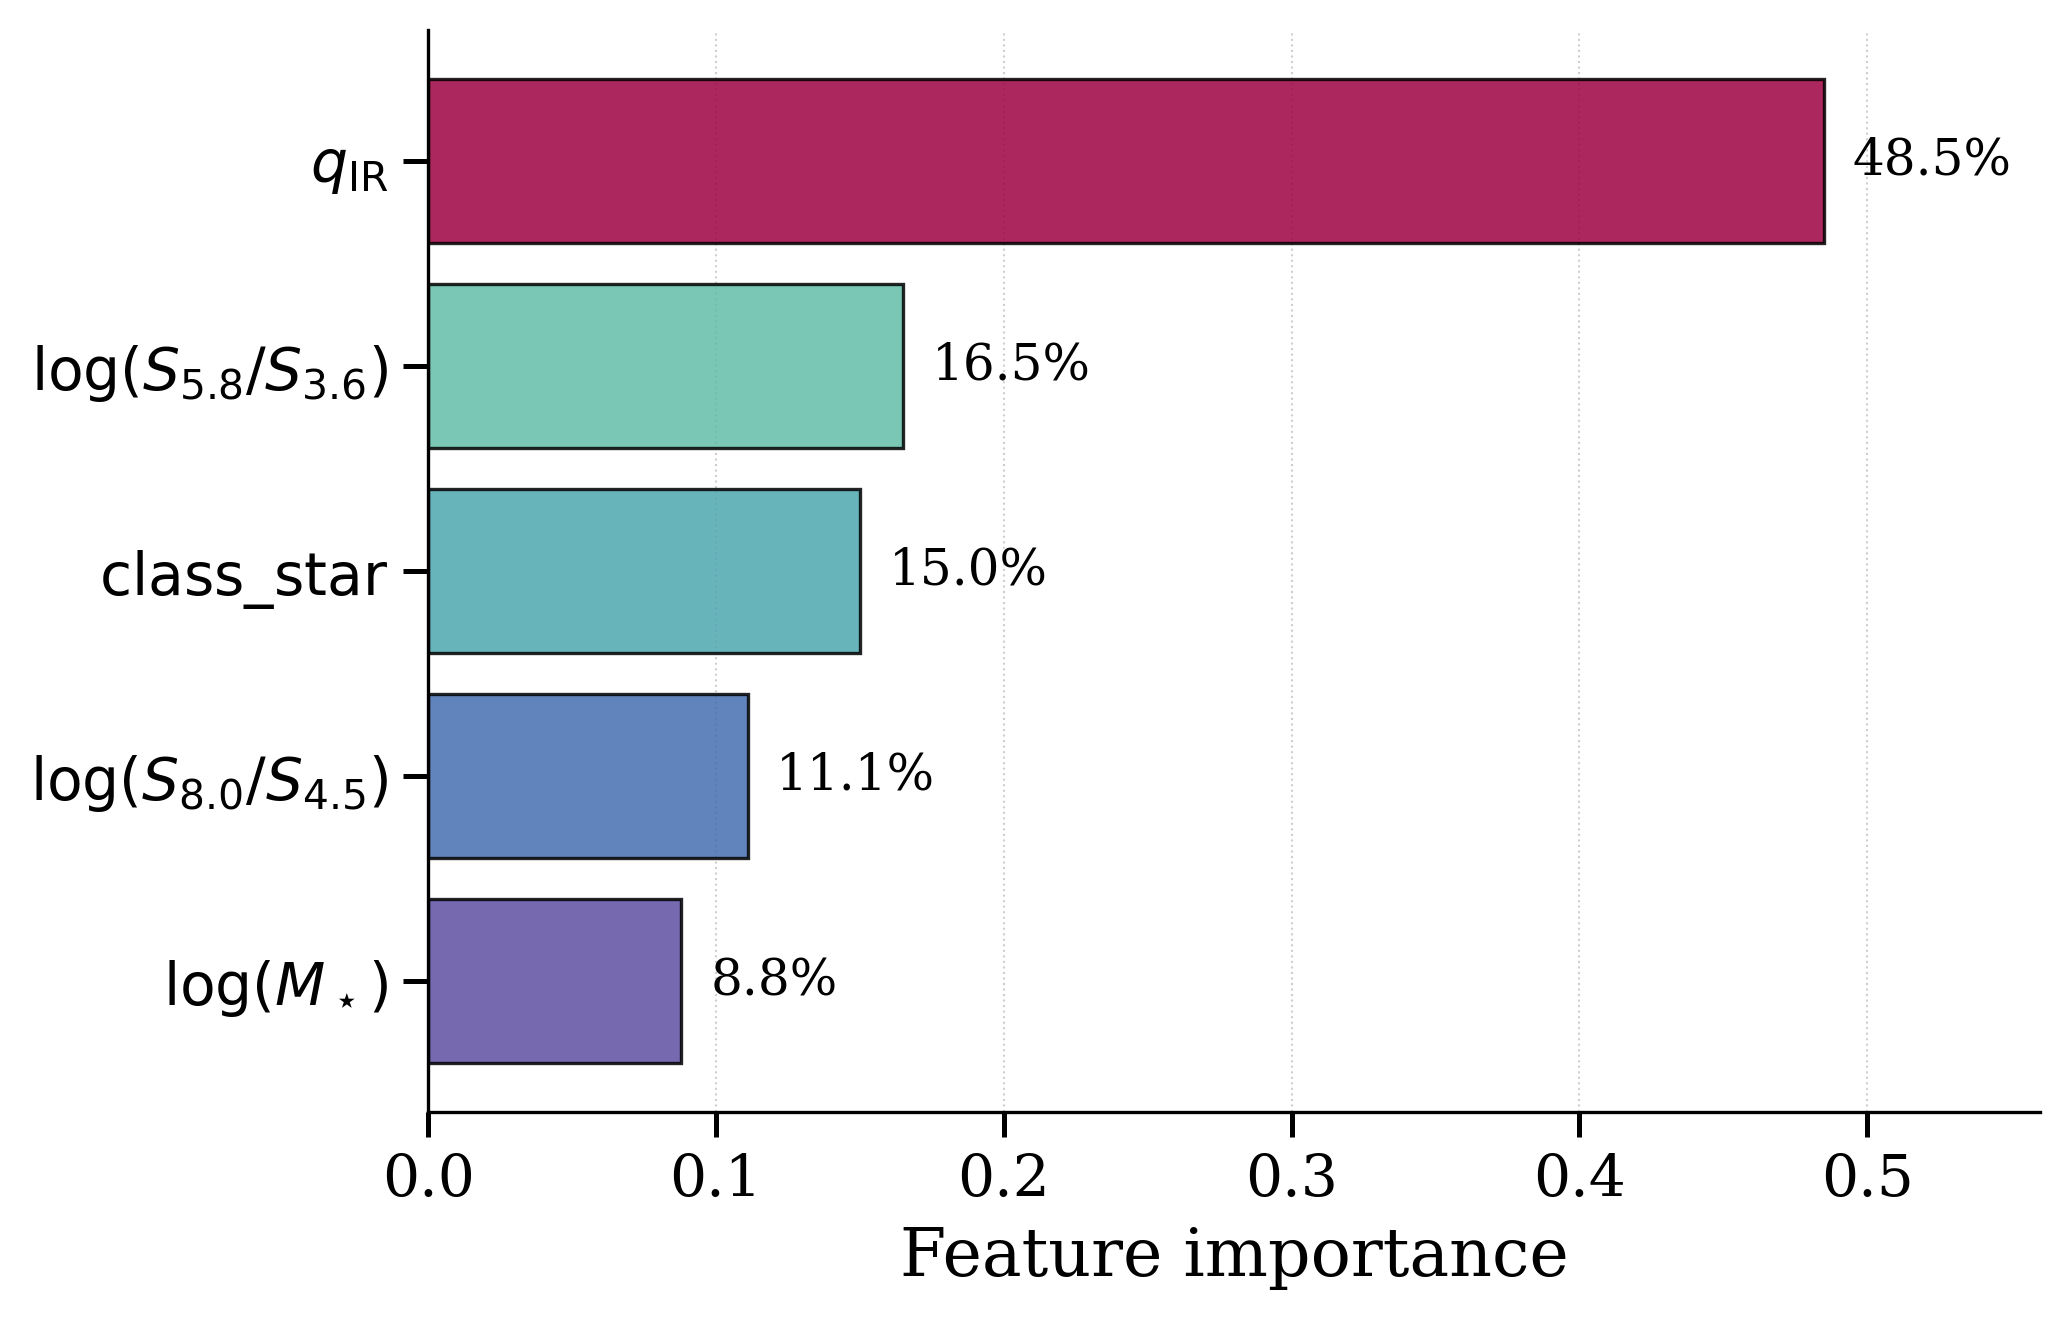

Figure saved as: feature_importance_ensemble.pdf

Feature Importance Summary:
$\log(M_\star)$     : 0.088 (  8.8%)
$\log(S_{8.0}/S_{4.5})$: 0.111 ( 11.1%)
$\text{class\_star}$: 0.150 ( 15.0%)
$\log(S_{5.8}/S_{3.6})$: 0.165 ( 16.5%)
$q_{\mathrm{IR}}$   : 0.485 ( 48.5%)


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm

# Your ensemble-averaged feature importances from 1000 runs
importances = np.array([0.088, 0.150, 0.485, 0.111, 0.165])  # [M_star, class_star, q_IR, S8/S4.5, S5.8/S3.6]
importances_std = np.array([0.018, 0.028, 0.032, 0.021, 0.025])  # 1-sigma uncertainties

feature_names = [
    r'$\log(M_\star)$',
    r'$\text{class\_star}$',
    r'$q_{\mathrm{IR}}$',
    r'$\log(S_{8.0}/S_{4.5})$',
    r'$\log(S_{5.8}/S_{3.6})$'
]

# Build DataFrame
fi_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances,
    'std': importances_std
})

# Sort by importance (descending)
fi_top = fi_df.sort_values('importance', ascending=False)

# Normalize importances for coloring (0 to 1)
imp_norm = (fi_top['importance'] - fi_top['importance'].min()) / (
    fi_top['importance'].max() - fi_top['importance'].min()
)

# Use perceptually uniform colormap: Spectral_r (most important = red, least = blue)
colors = cm.Spectral_r(imp_norm.values)

# Reverse order so most important is on top (matches MNRAS convention)
fi_top = fi_top.iloc[::-1]
colors = colors[::-1]
imp_norm = imp_norm.iloc[::-1]

# Set up figure styling
plt.rcParams.update({
    'font.family': 'serif',
    'font.size': 10,
    'axes.linewidth': 0.8,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9,
})

fig, ax = plt.subplots(figsize=(7, 4.5), dpi=300)

# Create horizontal bar plot WITHOUT error bars
bars = ax.barh(
    fi_top['feature'],
    fi_top['importance'],
    color=colors,
    edgecolor='black',
    linewidth=0.8,
    alpha=0.85
)

# Labels and title
ax.set_xlabel('Feature importance', fontsize=16)

# Light vertical grid for easier reading
ax.xaxis.grid(True, linestyle=':', linewidth=0.5, alpha=0.6)
ax.set_axisbelow(True)

# Remove top and right spines
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.tick_params(axis='both', which='major', labelsize=14, length=6, width=1.2)

# Add value labels at the end of bars with percentages
for bar, val in zip(bars, fi_top['importance']):
    ax.text(
        val + 0.01,  # Position: end of bar + small gap
        bar.get_y() + bar.get_height()/2,
        f'{val*100:.1f}%',
        va='center',
        ha='left',
        fontsize=12)

# Set x-axis limits to avoid label overlap
ax.set_xlim(0, 0.56)

# Tight layout
plt.tight_layout()

# Save
plt.savefig('feature_importance_ensemble.pdf', dpi=300, bbox_inches='tight')
plt.savefig('feature_importance_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure saved as: feature_importance_ensemble.pdf")
print("\nFeature Importance Summary:")
print("=" * 60)
for idx, row in fi_top.iterrows():
    print(f"{row['feature']:20s}: {row['importance']:.3f} ({row['importance']*100:5.1f}%)")
